<a href="https://colab.research.google.com/github/susannapaoli/hateful-speech-memes/blob/main/Multimodal%20Experiments/DEHATE_BERT_%2B_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/susannapaoli/multimodal-memes.git

Cloning into 'multimodal-memes'...
remote: Enumerating objects: 499, done.
remote: Counting objects: 100% (234/234), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 499 (delta 139), reused 223 (delta 131), pack-reused 265
Receiving objects: 100% (499/499), 4.39 MiB | 11.47 MiB/s, done.
Resolving deltas: 100% (252/252), done.


**Get data from Kaggle**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
files.upload()

Mounted at /content/drive


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pierluigimancinelli","key":"5d0facd662d10742d2f3607ad25f6658"}'}

In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!pwd

/content


In [7]:
!kaggle datasets download -d parthplc/facebook-hateful-meme-dataset

100% 3.35G/3.35G [02:22<00:00, 26.0MB/s]
100% 3.35G/3.35G [02:22<00:00, 25.2MB/s]


In [8]:
!unzip /content/facebook-hateful-meme-dataset.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: data/img/49758.png      
  inflating: data/img/49762.png      
  inflating: data/img/49785.png      
  inflating: data/img/49786.png      
  inflating: data/img/49802.png      
  inflating: data/img/49805.png      
  inflating: data/img/49806.png      
  inflating: data/img/49807.png      
  inflating: data/img/49810.png      
  inflating: data/img/49826.png      
  inflating: data/img/49831.png      
  inflating: data/img/49832.png      
  inflating: data/img/49836.png      
  inflating: data/img/49850.png      
  inflating: data/img/49856.png      
  inflating: data/img/49861.png      
  inflating: data/img/49863.png      
  inflating: data/img/49867.png      
  inflating: data/img/49870.png      
  inflating: data/img/50124.png      
  inflating: data/img/50126.png      
  inflating: data/img/50129.png      
  inflating: data/img/50137.png      
  inflating: data/img/50142.png      
  inflating: data/img/50146.png      


In [9]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.2 MB/s eta 0:00:00


In [10]:
'''
IMPORTING NECESSARY MODULES
'''

import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

sys.path.append('/content/multimodal-memes/DEHATE_BERT')
sys.path.append('/content/multimodal-memes')
sys.path.append('/content/multimodal-memes/Utils')
sys.path.append('/content/multimodal-memes/Data')
sys.path.append('/content/multimodal-memes/Resnet')
sys.path.append('/content/multimodal-memes/Data/data/img')

from dataloader import myfusiondataset
#from Load_model import load
from plot_curves import plot_loss, plot_acc
from multimodal_trainer import train, test_classify

'''
For ResNet/ ResNeXt
'''
from resnet_model import ResNet,Bottleneck, resnext101_32x8d


'''
For BERT
'''
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

**Device**

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


**Dataloading Scheme**

In [12]:
%cd /content/data

/content/data


In [13]:
trainlist = 'train.jsonl'
validlist = 'dev.jsonl'

In [14]:
'''
Train Dataloader
''' 
train_dataset = myfusiondataset(trainlist, name='train')          
train_dataloader = data.DataLoader(train_dataset, shuffle= True, batch_size = 32, num_workers=8,pin_memory=True)


'''
Validation Dataloader
''' 
validation_dataset = myfusiondataset(validlist, name='valid')         
validation_dataloader = data.DataLoader(validation_dataset, shuffle=False, batch_size = 16, num_workers=8,pin_memory=True)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(

**Model Definition**

In [15]:
'''
Model1 ResNeXt101_32x8d
'''
Image_model = resnext101_32x8d()

Image_model.fc = nn.Sequential(
    nn.Linear(Image_model.fc.in_features, 2)
    )

Image_model = nn.DataParallel(Image_model).to(device)

Image_model.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): S

In [16]:
'''
Model 2 BERT

Load BertForSequenceClassification, the pretrained DEHATE_BERT model with a single linear classification layer on top.
''' 

Text_model = BertForSequenceClassification.from_pretrained(
    "Hate-speech-CNERG/dehatebert-mono-english", 
    num_labels = 2,   
    output_attentions = False, 
    output_hidden_states = True
)

Text_model = nn.DataParallel(Text_model).to(device)


In [17]:
'''
Fusion
'''
class FusionNet(nn.Module):
    
    def __init__(self, num_classes, drop_prob = 0.1):
        super(FusionNet, self).__init__()
        
        self.pooler = nn.Linear(in_features=768, out_features=768)
        
        self.concat = nn.Linear(in_features=768+2048, out_features= 512)
        
        self.bn = nn.BatchNorm1d(512)
        self.bn1 = nn.BatchNorm1d(768)
        self.bn2 = nn.BatchNorm1d(2048)
    
        self.dropout = nn.Dropout(drop_prob)
        
        self.classify = nn.Linear(in_features = 512, out_features = num_classes)
        
        
    def forward(self, text_features, image_features):
        text_features = torch.tanh(self.pooler(text_features))
        text_features = self.dropout(text_features)

        text_features = self.bn1(text_features)
        image_features = self.bn2(image_features)
      
        fused =  torch.cat((text_features, image_features), dim=1)
      
        x = self.concat(fused)
  
        x = F.tanh(self.bn(x))          
  
        x = F.tanh(self.classify(x)) 
  

        return x



In [18]:
Fusion_model = FusionNet(num_classes = 2 , drop_prob = 0.1)
Fusion_model = nn.DataParallel(Fusion_model).to(device)

**Hyperparameters**

In [19]:
'''
Loss Function
'''
criterion = nn.CrossEntropyLoss()


'''
Optimizer
'''
optimizer = torch.optim.SGD(Fusion_model.parameters(), lr=0.01, weight_decay=1e-4, momentum=0.9)

'''
Number of training epochs.
'''
num_Epochs = 5

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 4, gamma = 0.1)

In [20]:
model_name = 'Concatenation_DeHate'
model_path = './saved_model_checkpoints/'+model_name

In [21]:
writer = SummaryWriter(model_name)

train_loss, val_loss, val_acc = train(Image_model, Text_model, Fusion_model, train_dataloader, validation_dataloader, criterion, optimizer, lr_scheduler, model_path, writer, device, epochs = 5)

writer.flush()
writer.close()

Epoch:  1
training loss =  0.6494617277294173
Validation Loss: 0.8182	Validation Accuracy: 0.5020
Epoch:  2
training loss =  0.6278159263214671
Validation Loss: 0.7965	Validation Accuracy: 0.5120
Epoch:  3
training loss =  0.6195908829681855
Validation Loss: 0.7407	Validation Accuracy: 0.5660
Epoch:  4
training loss =  0.628582010479798
Validation Loss: 0.8092	Validation Accuracy: 0.5340
Epoch:  5
training loss =  0.598550020528019
Validation Loss: 0.8151	Validation Accuracy: 0.5300


**Plot for training and validation loss**

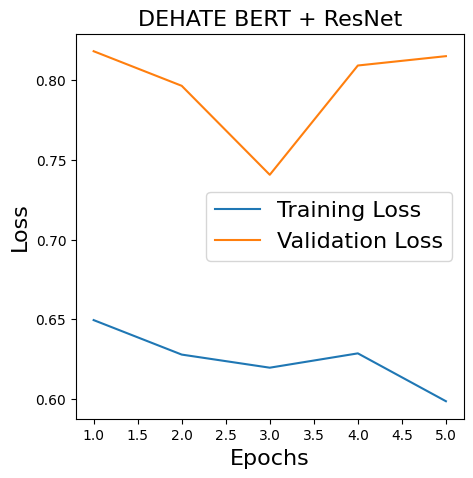

In [22]:
plot_loss(num_Epochs, train_loss, val_loss, 'DeHate BERT + ResNet')

**Plot of the accuracy of the model**

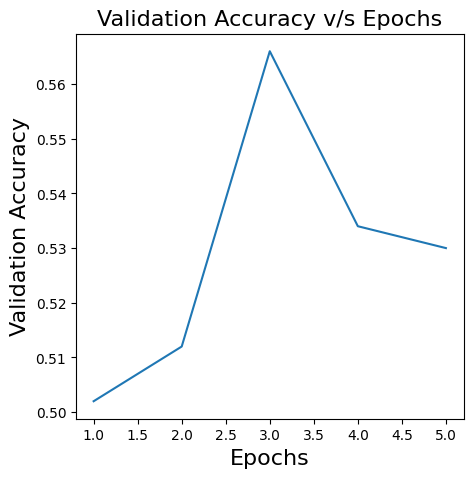

In [23]:
plot_acc(num_Epochs, val_acc)